In [ ]:
import cupy as cp
import pandas as pd
import seaborn as sns

Play on a grid, show in pygame

In [ ]:
# Constants
global width
width = 800
global height
height = 400
global fps
fps =  30

# Transition probabilities - we should investigate parameters of this and relevant bifurcations
p_settle = 0.5 # Probability and grid member invades an empty square
p_rock_dominates = p_paper_dominates = p_scissors_dominates = 0.4 #Probability of colonizing neighbour





In [ ]:
# build game
class RockPaperScissors():
  # build grid
  def __init__(self):
    self.grid = cp.zeros((width, height))

  #Assign rock->1, paper->2, scissors->3
  #Thus 3 > 2 > 1 > 3 > ...

  def seeding(self):
    ''' Get starting positions of our grid '''
    density = 0.15 #probability of seeding grid
    # Sample values for the entire grid
    values = cp.random.choice([1, 2, 3], size=(width, height))
    toggles = cp.random.choice([True, False], size=(width, height), p=[density, 1-density])
    # Update the grid where toggle is True
    self.grid = cp.where(toggles, values, 0)


  def update(self):
    '''
    Markov process where we update our grid based on starting probabilities.
    Should do in place (updating self), and in parallel rather than in a loop
    Currently returns: new grid matrix
    '''
    # Define the update kernel using cupy.ElementwiseKernel
    update_kernel = cp.ElementwiseKernel(
        'raw T grid, int width, int height, float p_settle, float p_rock_dominates, float p_paper_dominates, float p_scissors_dominates',
        'T new_grid',
        '''
        int x = i % width;
        int y = i / width;

        T current_cell = grid[i];
        new_grid = current_cell; // Initialize with the current value

        // Define neighbors' relative positions
        int dx[] = {-1, -1, -1, 0, 0, 1, 1, 1};
        int dy[] = {-1, 0, 1, -1, 1, -1, 0, 1};

        // Count neighbors of each type
        int rock_neighbors = 0;
        int paper_neighbors = 0;
        int scissors_neighbors = 0;
        int empty_neighbors = 0;

        for (int j = 0; j < 8; ++j) {
            int nx = x + dx[j];
            int ny = y + dy[j];

            // Check boundaries
            if (nx >= 0 && nx < width && ny >= 0 && ny < height) {
                T neighbor_cell = grid[ny * width + nx]; // Access neighbor using linear index
                if (neighbor_cell == 1) {
                    rock_neighbors++;
                } else if (neighbor_cell == 2) {
                    paper_neighbors++;
                } else if (neighbor_cell == 3) {
                    scissors_neighbors++;
                } else {
                    empty_neighbors++;
                }
            }
        }

        // Apply update rules based on current cell and neighbors

        // If the current cell is empty (0)
        if (current_cell == 0) {
            // Settle with a random neighbor type with probability p_settle
            if (empty_neighbors < 8 && (float)cp::random::rand() < p_settle) {
                // Choose a random non-empty neighbor
                int neighbor_type = 0;
                while (neighbor_type == 0) {
                  int random_neighbor_index = (int)(cp::random::rand() * 8);
                   int nx = x + dx[random_neighbor_index];
                   int ny = y + dy[random_neighbor_index];
                   if (nx >= 0 && nx < width && ny >= 0 && ny < height) {
                     neighbor_type = grid[ny * width + nx];
                   }
                }
                 new_grid = neighbor_type;
            }
        } else { // If the current cell is not empty
            // Check for domination by neighbors

            // Rock (1) dominates Scissors (3)
            if (current_cell == 1 && scissors_neighbors > 0) {
                if ((float)cp::random::rand() < p_rock_dominates) {
                    new_grid = 3; // Becomes Scissors
                }
            }
            // Paper (2) dominates Rock (1)
            else if (current_cell == 2 && rock_neighbors > 0) {
                 if ((float)cp::random::rand() < p_paper_dominates) {
                    new_grid = 1; // Becomes Rock
                }
            }
            // Scissors (3) dominates Paper (2)
            else if (current_cell == 3 && paper_neighbors > 0) {
                 if ((float)cp::random::rand() < p_scissors_dominates) {
                    new_grid = 2; // Becomes Paper
                }
            }
        }

        ''',
        'update_kernel'
    )

    # Create a new grid to store the updated values
    new_grid = cp.copy(self.grid)

    # Apply the kernel to the grid
    update_kernel(self.grid, width, height, p_settle, p_rock_dominates, p_paper_dominates, p_scissors_dominates, new_grid)

    # Update the grid in place
    self.grid = new_grid
    return self.grid

Because pygame is not colab-enabled, we save output logs and visualize on a local device in pygame

In [ ]:
# Create grid and initialize. Visualize in pygame, with different colors
epochs = 5000 #Number of epochs

#Initialize
log = []
game = RockPaperScissors()
game.seeding()

for i in range(epochs):
  game.update()
  log.append(i, cp.asnumpy(game.grid))


#Save log as csv where column 1 is epoch, column 2 is grid
pd.DataFrame(log).to_csv('log.csv', index=False, header=False)



Visualizing initial seeding

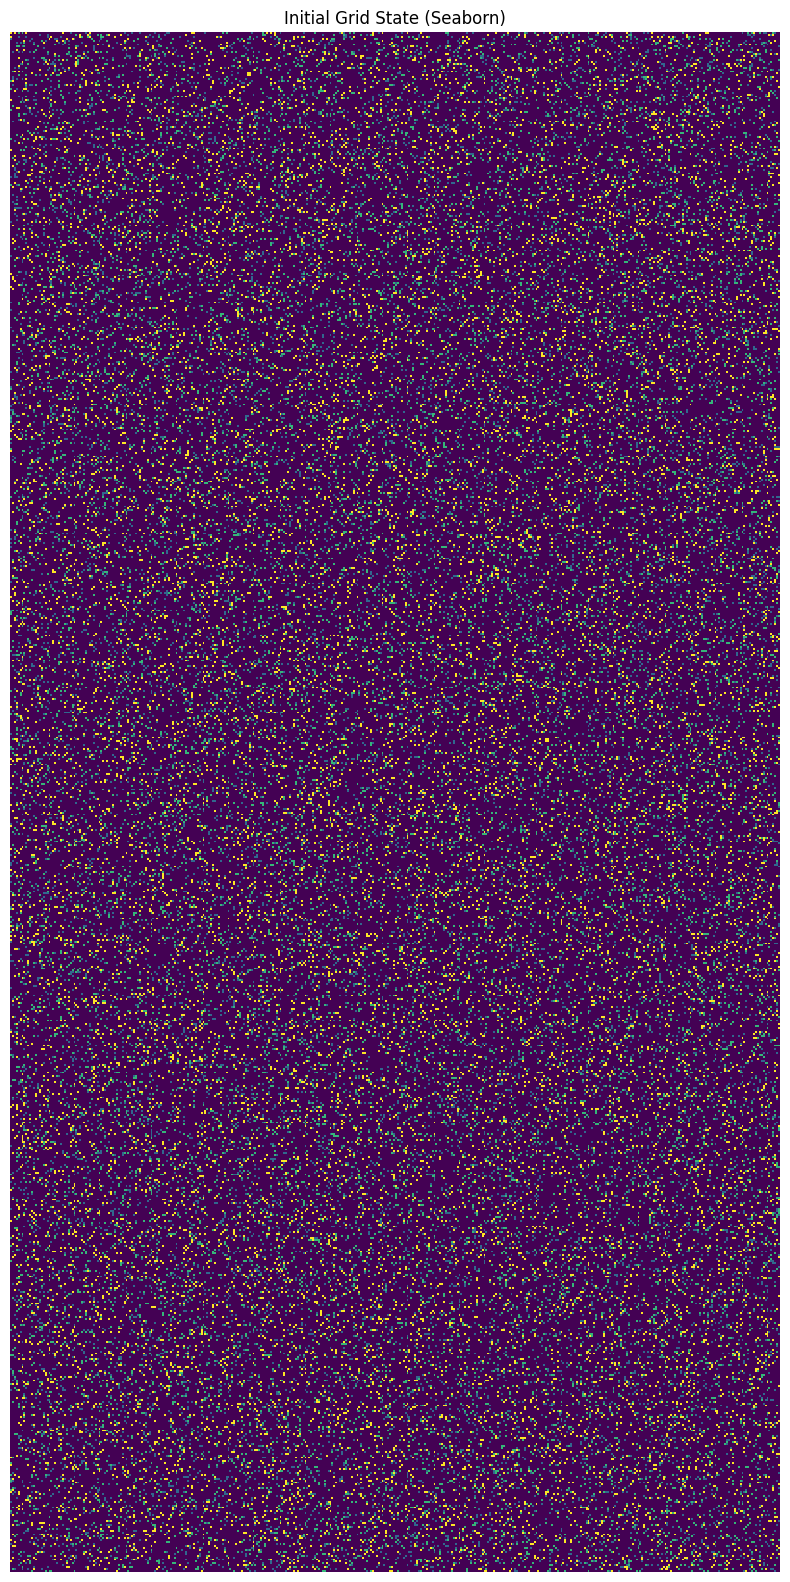

In [ ]:
import matplotlib.pyplot as plt
# hashtag
# Create an instance of the game
game = RockPaperScissors()
game.seeding()

# Convert the CuPy grid to a NumPy array
numpy_grid = cp.asnumpy(game.grid)

# Use Seaborn to create a heatmap
plt.figure(figsize=(width/20, height/20)) # Adjust figure size based on grid dimensions
sns.heatmap(numpy_grid, cmap="viridis", cbar=False, square=True)
plt.title("Initial Grid State (Seaborn)")
plt.axis('off') # Hide axes
plt.show()